# SIA calving model

Implementation of a simple calving law. The notebook starts by solving for basal elevation. Once the bed is determined, we forward model with calving.

The inversion follows the approach of [van Pelt et al. (2013)](https://tc.copernicus.org/articles/7/987/2013/), iteratively adjusting the bed to minimize the surface misfit after forward modeling. The procedure is implemented using the [centerflow](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow.ipynb) package, which is built on top of Firedrake and icepack. 

Start by choosing a glacier:

In [1]:
name = 'Luggye' #choose your glacier from the list below, or add to it

freeboard = 50 #how high is the water level relative to the terminus?
c = -0.1 #tuning parameter for calving law

## Glacier identification

Hard coding IDs for Bechung, Thorthormi, Rahpstreng, and Luggye. For other glaciers, it will be necessary to find their RGIIDs from v. 7.

In [2]:
glaciers = {
    'Luggye': {
        'name': 'Luggye',
        'rgiid_7': '15-09534',
    },
    'Raphstreng': {
        'name': 'Raphstreng',
        'rgiid_7': '15-09531',
    },
    'Thorthormi': {
        'name': 'Thorthormi',
        'rgiid_7': '15-09532',
    },
    'Bechung': {
        'name': 'Bechung',
        'rgiid_7': '15-09530',
    }
}

## Imports

In [3]:
from firedrake import *
import icepack
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import pandas as pd
from tqdm import trange

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow import *

## Paths

In [4]:
rgiid_7 = glaciers[name]['rgiid_7']
base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
outline6_path = base_path + 'outlines/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'

rgiid_6 = rgi6_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path, rgi6_path = outline6_path)
latlon = latlon_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path)

velocity_path = base_path + f'velocity/{rgiid_7}/MedianVelocity_2006.tif'
thickness_path = base_path + f'thickness/farinotti_ensemble/RGI60-{rgiid_6}_thickness.tif'
smb_path = base_path + 'smb/dussailant/ASE_gla_MEAN-CAL-mass-change-series_obs_unobs.csv'
# smb_path = base_path + 'smb/karma/prf_glacier_ctl.csv'

dem_path = base_path + f'elevation/farinotti/surface_DEM_RGI60-{rgiid_6}.tif'
dem_year = 2017 #the year corresponding to the DEM (probably somewhat earlier than RGI6, which was released in 2017)
start_year, end_year = 2010, 2020

dhdt_path = base_path + f'elevation/elevation_change/{start_year}_2020_dhdt/{latlon}_{start_year}-01-01_2020-01-01_dhdt.tif'
figures_path = '/eejit/home/bezu0001/icepack/figures/lake_calving'

## Load data

In [5]:
n_cells = 1000
Δx = 500 #give the data an initial couple hundred meters initially, just in case the glacier ends up advancing. 
mesh = centerline_mesh(rgiid = rgiid_7, centerline_path = centerline_path, outline_path = outline_path, n_cells = n_cells, extra_length = Δx)
mesh = crop_mesh(mesh = mesh, data_path = dem_path) #for cases where the DEM doesn't cover the entire flowline
X = mesh.X
cell_size = mesh.glacier_length/n_cells
print('cell size = ', cell_size, 'metres')
smoothing_params = {'window': mesh.glacier_length/4, 'mesh': mesh}

thickness = map_to_mesh(mesh = mesh, data_path = thickness_path)
dem = map_to_mesh(mesh = mesh, data_path = dem_path)
bed_val = dem.last_nonzero_value - thickness.last_nonzero_value #obtain the bed value at the last on-glacier location
dem = map_to_mesh(mesh = mesh, data_path = dem_path, ice_free_value = bed_val) #and use it to refine the final on-glacier dem value

# smb = map_to_mesh(mesh = mesh, data_path = smb_path, key_value = ' altitude', key_dataset = dem.data, data_value = 'ave_mb')

try:
    velocity = map_to_mesh(mesh = mesh, data_path = velocity_path, ice_free_value = 0)
except:
    pass

dH_dt = map_to_mesh(mesh = mesh, data_path = dhdt_path, ice_free_value = 0)
dHdt_smoothed = smooth_function(function = dH_dt.data, **smoothing_params)
mean_dHdt  = float(assemble(dH_dt.data*dx)/mesh.glacier_length)

Q = dem.data.function_space()
print('mean thinning rate:', mean_dHdt, 'meters per year')

cell size =  9.094884980707148 metres
Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_ensemble/RGI60-15.02373_thickness.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/farinotti/surface_DEM_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/farinotti/surface_DEM_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/velocity/15-09534/MedianVelocity_2006.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/elevation_change/2010_2020_dhdt/N28E090_2010-01-01_2020-01-01_dhdt.tif from EPSG:32646 to EPSG:4326
mean thinning rate: -0.4623052503722102 meters per year


## Initialize the flow model

In [6]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))

opts = {
    'dirichlet_ids': [1] 
}

flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

Δt = 1/10
num_timesteps = int((end_year - start_year)/Δt)

## Initialize reference surfaces

In [7]:
s_1 = dem.data.copy(deepcopy = True)
s_1.year = dem_year

s_0 = Function(Q).project(s_1 - dHdt_smoothed*(dem_year - start_year))
s_0.year = start_year

s_2 = Function(Q).project(dem.data + dHdt_smoothed*(end_year - dem_year))
s_2.year = end_year

u = Function(Q).project(Constant(0))

## Initialize SMB data

SMB data consist of single glacier-averaged values at each timestep. The inversion performs poorly with data this coarse. We can create slightly more realistic data by assuming that SMB varies with elevation via some lapse rate, and we construct a spatially variable SMB field whose spatial average is the appropriate value. The lapse rate is chosen so that the spread in SMB values is similar to the spread in the observed thinning rate. 

In [8]:
df = pd.read_csv(smb_path)
row = df.loc[df["RGIId"] == f'RGI60-{rgiid_6}']

dem_adjusted = Function(Q).project(dem.data - dem.last_nonzero_value) #shift DEM so that the glacier front is at 0
lapse_rate = 0.003 #obtained by trial and error

smb_expr = lapse_rate*dem_adjusted #SMB is of the form smb = a*elevation + b, where a is the lapse rate and b is to be determined
temp_mean = assemble(smb_expr*dx)/mesh.glacier_length #the spatial mean of the expression smb = a*elevation + 0, which will need correcting

smb_dict = {} #list of glacier-wide specific SMB values (one per year)
for step in range(num_timesteps):
    decimal_year = s_0.year + step*Δt
    int_year = s_0.year + int(step*Δt)
    smb_mean = float(row[str(int_year)].iloc[0])
    b = smb_mean - temp_mean #how far off is our guess?
    entry = Function(Q).project(smb_expr + b) #adjust by this much
    smb_dict[decimal_year] = entry

## Invert for basal topography

In [9]:
surface_1 = s_0
surface_2 = s_2

inversion_params = {
    'model': flow_model,
    'solver': flow_solver,
    'mesh': mesh,
    'fluidity': A,
    'surface': surface_1,
    'surface_2': surface_2,
    'accumulation': smb_dict,
}
    
inversion = solve_bed(K = 0.1, num_iterations = 50, thickness_guess = firedrake.Constant(200), velocity = u, 
                      **inversion_params)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.91s/it]


## Calving modeling

We implement the simple calving law similar to that introduced by [Oerlemans and Nick, 2005](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F), in which the calving flux, in cubic meters per year, is given as 

$$ F_c = cdH_tw_t $$

where $d$ is water depth, $H_t$ is terminus thickness, $w_t$ is the terminus width, and $c$ is a tuning parameter whose units are a$^{-1}$. We modify this to a calving rate $u_c$ by dividing out the width dimension, and normalizing via:

$$u_c = c\sqrt{dH_t}.$$

We begine by specifying a given lake level, with water depth the difference between that level and the bed. At each timestep, we assume the glacier incrementally moves forward in accordance with its terminal velocity, and that it moves backward (if applicable) in accordance with the calving rate specified above.

In [10]:
mesh_0 = mesh
mesh_1 = mesh
mesh_2 = mesh

ΣΔx = -700
s = surface_1.copy(deepcopy = True)
bed_0 = inversion.bed
Q = bed_0.function_space()
bed = bed_0.copy(deepcopy = True)
bed0_array = np.array(bed_0.at(mesh_0.X, tolerance = 1e-10))
u = inversion.velocity
H = Function(Q).project(s - bed)
H_0 = Constant(H.at(0))

w = s.at(mesh.mesh_length) - freeboard #water level
d = Function(Q).project(w - bed)
d = Function(Q).project(max_value(d, 0))
a = Function(Q).project(smb_dict[surface_1.year + step*Δt])
print(f'initial water depth = {d.at(mesh_1.mesh_length)} m')

os.chdir(figures_path)
calving_rates = []
advance_rates = []

model_time = surface_2.year - surface_1.year

initial water depth = 116.245869522028 m


In [11]:
num_timesteps = int(model_time/Δt)
for step in trange(num_timesteps):

    H_t = H.at(mesh_1.mesh_length)
    s_t = s.at(mesh_1.mesh_length)
    d = Function(Q).project(w - bed)
    d_t = d.at(mesh_1.mesh_length)
    u_t = u.at(mesh_1.mesh_length)
    advance_rates.append(u_t)
    a_t = a.at(mesh_1.mesh_length)
    
    
    u_c = c*np.sqrt(max(H_t*d_t, 0))
    calving_rates.append(u_c)
    Δx = ((u_c + u_t)*Δt)
    ΣΔx += Δx
    
    mesh_2 = centerline_mesh(rgiid = rgiid_7, centerline_path = centerline_path, outline_path = outline_path, n_cells = n_cells, extra_length = ΣΔx)
    bed = extend_to_mesh(source_function = bed_0, source_mesh = mesh_0, target_mesh = mesh_2).data
    s = extend_to_mesh(source_function = s, source_mesh = mesh_1, target_mesh = mesh_2, ice_free_value = s_t).data
    H = extend_to_mesh(source_function = H, source_mesh = mesh_1, target_mesh = mesh_2, ice_free_value = H_t).data
    d = extend_to_mesh(source_function = d, source_mesh = mesh_1, target_mesh = mesh_2, ice_free_value = d_t).data
    u = extend_to_mesh(source_function = u, source_mesh = mesh_1, target_mesh = mesh_2, ice_free_value = u_t).data
    a = extend_to_mesh(source_function = smb_dict[surface_1.year + step*Δt], source_mesh = mesh_0, target_mesh = mesh_2, ice_free_value = a_t).data
    mesh_1 = mesh_2
    
    Q = s.function_space()
    
    flow_model = icepack.models.ShallowIce()
    flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)
    
    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = a)
    s = icepack.compute_surface(bed = bed, thickness = H)

    bed_array = np.array(bed.at(mesh_1.X, tolerance = 1e-10))
    s_array = np.array(s.at(mesh_1.X, tolerance = 1e-10))
    water_mask = (w > bed0_array) & (mesh_0.X > mesh_1.mesh_length)
    
    
    plt.figure()
    plt.plot(mesh_1.X, s.at(mesh_1.X, tolerance = 1e-10), color = 'blue', label = 'surface')
    plt.plot(mesh_0.X, bed_0.at(mesh_0.X, tolerance = 1e-10), color = 'k', label = 'bed')
    plt.fill_between(mesh_1.X, bed_array, s_array, color = 'skyblue', alpha = 0.6, label = 'glacier ice')
    plt.fill_between(mesh_0.X, bed0_array, w, color = 'blue', where = water_mask, label = 'water')
    plt.legend(loc = 'upper right')
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.xlim(7000, mesh_0.mesh_length)
    plt.ylim(4300, 4800)
    plt.grid()
    plt.savefig(f'{step}') 
    if step < num_timesteps:
        plt.close()
    else:
        plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.19s/it]


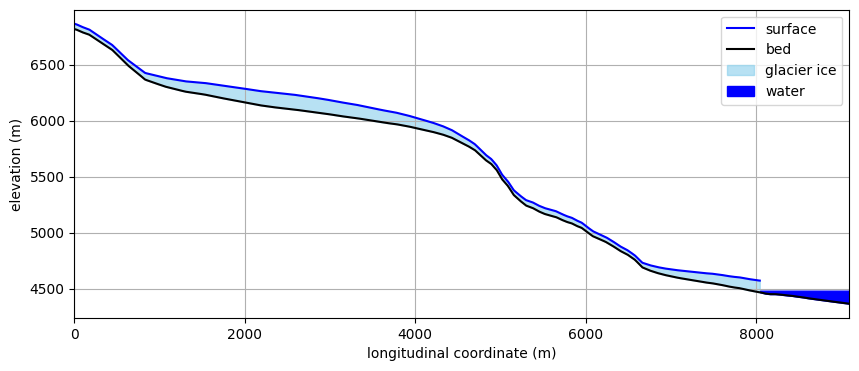

In [12]:
plt.figure(figsize = (10, 4))
plt.plot(mesh_1.X, s.at(mesh_1.X, tolerance = 1e-10), color = 'blue', label = 'surface')
plt.plot(mesh_0.X, bed_0.at(mesh_0.X, tolerance = 1e-10), color = 'k', label = 'bed')
plt.fill_between(mesh_1.X, bed_array, s_array, color = 'skyblue', alpha = 0.6, label = 'glacier ice')
plt.fill_between(mesh_0.X, bed0_array, w, color = 'blue', where = water_mask, label = 'water')
plt.legend(loc = 'upper right')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.xlim(0, mesh_0.mesh_length)
# plt.ylim(4300, 4800)
plt.grid()
plt.show()